# Predicting Average Temperature Using Weather Data

This notebook is a companion to the other notebook in which I used logistic regression to predict whether there was precipitation on a given day. In this notebook, I'm going to use time series methods to explore monthly temperature patterns in Atlanta, GA. I'm not a meteorologist, so I don't have much in-depth knowledge about weather patterns, but I hope to show that simple models can still give insight into a problem and can provide an entry point for futher study. 

The data used here was acquired from the NOAA weather database [here](https://www.ncdc.noaa.gov/cdo-web/datatools/lcd). These data were taken by equipment at 3 different airports in Atlanta from 1/1/10 to 12/31/19. While the altitudes of these airports vary within 60 meters, they are close enough that the 3 datasets can be combined to give similar measurements.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

from cleaning import *

from sklearn import metrics
import statsmodels.api as sm
import pmdarima as pm
from pmdarima.utils import tsdisplay

In [2]:
np.random.seed(42)

The first step is to import the data. I've created a function that accesses the csv files on GitHub and merges them into a large data frame. The details of this function can be found in "cleaning.py".

In [3]:
df = import_data()

The same dataset I used for the precipitation project also contains the relevant temperature data, so I use the same cleaning function to process the data:

In [4]:
df = condense_frame(df)

We can now begin to study how the average monthy temperature in Atlanta varies over a 10-year window. Doubtlessly, temperature is higly seasonal, which means that there is some pattern in the temperature data that repeats later in time. For instance, we would expect temperature to be the highest in summer and lowest in winter each year. This temporal pattern means that I can model temperature patterns and create a primitive temperature forecast using time like an explanatory variable. But first, the data contain daily measurements, so I condense the temperature data into monthy averages: 

In [5]:
avg = df['DailyAverageDryBulbTemperature'].resample('MS').mean()
avg.rename('MonthyAverageTemperature', inplace=True)

DATE
2010-01-01    38.118280
2010-02-01    39.428571
2010-03-01    50.387097
2010-04-01    64.366667
2010-05-01    73.139785
                ...    
2019-08-01    81.247312
2019-09-01    80.444444
2019-10-01    67.139785
2019-11-01    51.155556
2019-12-01    49.903226
Freq: MS, Name: MonthyAverageTemperature, Length: 120, dtype: float64

Condensing the data in this manner allows me to make use of efficient time series models that are simple to understand, but the tradeoff is that some granular information is lost. While some of this information is likely noise, we should be cautious about applying the resultant forecast to individual days and expecting good results. The forecast will be used to predict average monthly temperatures, not average daily temperatures. 

Before getting into forecasting monthly temperatures, it's a good idea to explore the data and visualize any obvious patterns. For this purpose, the [pmdarima](https://alkaline-ml.com/pmdarima/index.html) package provides many incredibly convenient functions to use on time series data, including a function that plots several important data characteristics:

<IPython.core.display.Javascript object>


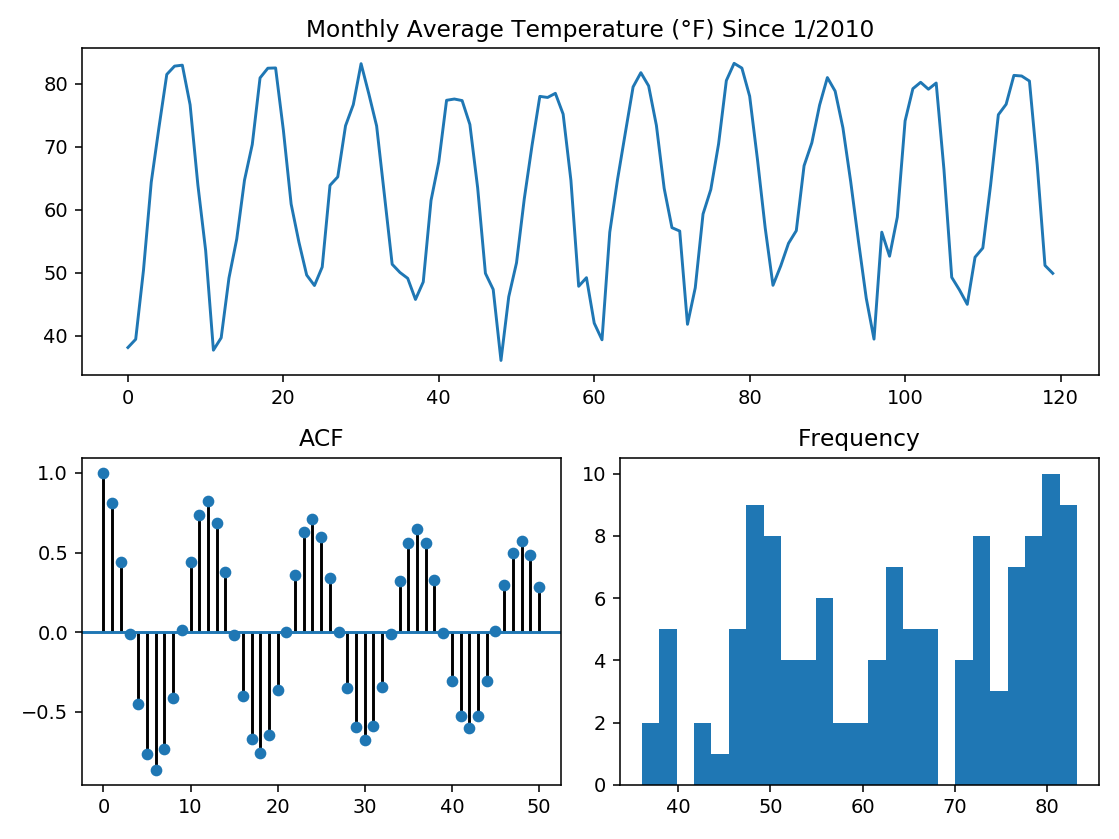

In [6]:
tsdisplay(avg, title='Monthly Average Temperature (°F) Since 1/2010')

The top panel is the average monthly temperature in Atlanta vs months since January, 2010. The overall pattern is periodic, indicating seasonality. The bottom left panel is the autocorrelation function for the temperature data. This function shows how correlated a temperature point in time is with another value some months further in time. We see that this function is also periodic, providing further evidence that the temperature data are seasonal. The bottom right panel is a simple histogram counting the number of months with a particular average temperature. The distribution is bimodal with peaks around 50°F and 80°F, respectively, most likely representing the most frequent average monthy temperatures in winter and summer, respectively. 

Furthermore, we can decompose our time series into components that reveal more underlying patterns in the temperature data. The [statsmodels](https://www.statsmodels.org/stable/index.html) package provides a seasonal decomposition method:

<IPython.core.display.Javascript object>


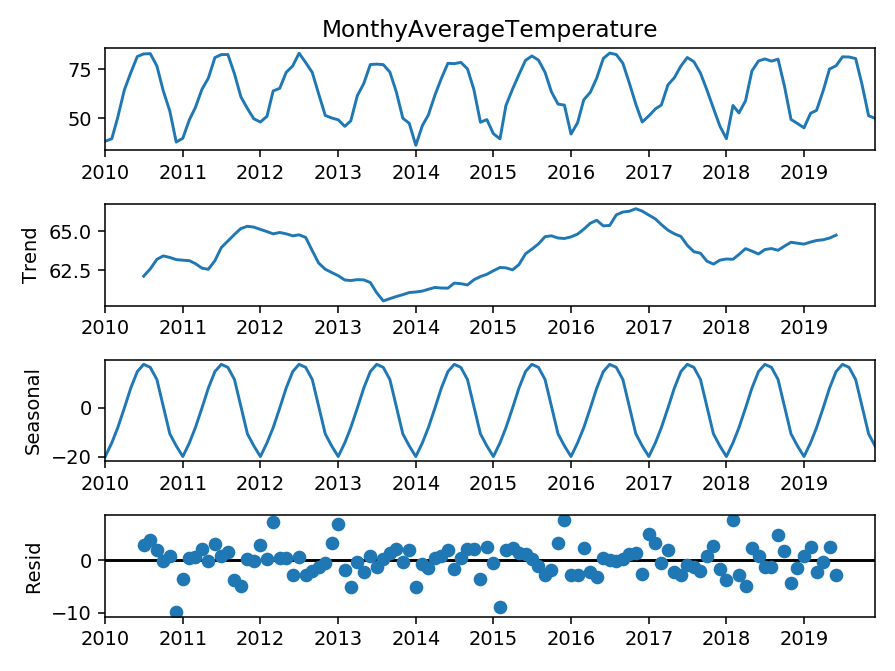

In [7]:
decomp = sm.tsa.seasonal_decompose(avg, model='additive')
fig = decomp.plot()

As expected, there is a dominating seasonal pattern to the temperature data. The trend panel shows a relatively cooler period in 2013 and a relatively hotter period in late 2016. The residuals appear randomly distributed around 0, showing little pattern in monthly deviations. 

Because time series data have time-dependent structures, the data cannot be split randomly into training and test sets as usual. For time seires, the test set is typically made using data at the end of the series. Here, I'll save the last 15 observations for testing.

Because of the dominant seasonality in the data, the temperature data are not stationary in time. One reason this is true is because the mean temperature is not constant over time; it varies cyclically. Many time series models require the data to be stationary, but there are techniques that can be used to render the temperature data stationary. So we need a model that incorporates seasonality and accounts for the data not being stationary. 

Fortunately, such a model exists. The model I will use is called the [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) model. This acronym stands for AutoRegressive Integrated Moving Average. We can understand what these terms mean by breaking them down into parts. The autoregressive part means that the model is a regression onto prior values in the time series, which accounts for autocorrelation. The integrated part means that the data used in the model are the differences between each temperature and the prior temperature. This technique is called differencing, and it's used to make data stationary in time. Moving average means that each prediction of the model depends on the current value and values in the past. These features are controlled by 3 hyperparameters (p,d,q), one for the order of autoregression, differencing, and moving average, respectively. 

However, the temperature data are highly seasonal, so the standard ARIMA model has to be modified to accommodate this behavior. A simple modification is to include a seasonal component in the model, which incorporates the temperature seasonality. The seasonal component of the model is also controlled by 3 hyperparameters (P,D,Q), each one corresponding to the seasonal order of autoregression, differencing, and moving average, respectively.

There is one final hyperparameter (m) that specifies how many steps are in 1 period of a time series. This number depends on the time frame used for the data. There are 12 months in a year, so this hyperparameter will be 12 for the temperature data.  

The challenge ahead is to find the best hyperparameters to create the best ARIMA model. I could guess which values to use, but this process would take many tries and may not result in the best model. A more efficient way of guessing is to perform a grid search over the hyperparameters. Fortunately, the pmdarima package provides an efficient automation of this process in the [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html#pmdarima.arima.AutoARIMA) method. This method finds the best ARIMA model for the temperature data by selecting the model that produces the lowest [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion). 

In [8]:
train, test = avg[:105], avg[105:]

In [9]:
model = pm.auto_arima(train, start_p=0, start_d=0, start_q=0, # Define ARIMA hyperparameter range
                             max_p=5, max_d=2, max_q=5, 
                             start_P=0, start_D=0, start_Q=0,
                             max_P=5, max_D=2, max_Q=5, m=12,
                             seasonal=True, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True,  
                             stepwise=True)  

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 12) (constant=True); AIC=852.475, BIC=857.783, Time=0.018 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 12) (constant=True); AIC=643.924, BIC=654.540, Time=0.452 seconds
Near non-invertible roots for order (1, 0, 0)(1, 0, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 12) (constant=True); AIC=721.166, BIC=731.782, Time=0.151 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 12) (constant=False); AIC=1176.949, BIC=1179.603, Time=0.006 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 12) (constant=True); AIC=763.452, BIC=771.414, Time=0.049 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 1, 12) (constant=True); AIC=652.124, BIC=665.394, Time=0.697 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 0, 12) (constant=True); AIC=646.104, BIC=656.719, Time=0.472 seconds
Fit ARIMA: (0, 0, 1)x(2, 0, 0, 12) (constant=True); AIC=843.528, BIC=856.798, Time=0.730 seconds
Near non-invertible

We can see the results of this process by accessing the summary:

In [10]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  105
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -317.962
Date:                            Thu, 14 May 2020   AIC                            643.924
Time:                                    19:45:54   BIC                            654.540
Sample:                                         0   HQIC                           648.226
                                            - 105                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.8689      1.346      2.874      0.004       1.231       6.507
ar.L1          0.4159      0.089      4.684      0.000       0.242       0.590
ar.S.L12       0.8954      0.041     21.953      0.000       0.815       0.975
sigma2        20.7216      2.668      7.767      0.000      15.493      25.950
===================================================================================
Ljung-Box (Q):                       54.72   Jarque-Bera (JB):                 5.35
Prob(Q):                              0.06   Prob(JB):                         0.07
Heteroskedasticity (H):               1.28   Skew:                            -0.48
Prob(H) (two-sided):                  0.47   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

All of the model terms are statistically unlikely to occur by chance. The optimal hyperparameters are an order of 1 for autoregression and seasonal autoregression and an order of 0 for everything else. 

It's a good idea to check whether the model is statistically valid. This means checking the assumptions of the model to see if they are satisfied on the training set. The main concerns are that the model produces residuals that have no clear pattern and that the autocorrelation has been removed. 

The statsmodel package provides a convenient summary:

<IPython.core.display.Javascript object>


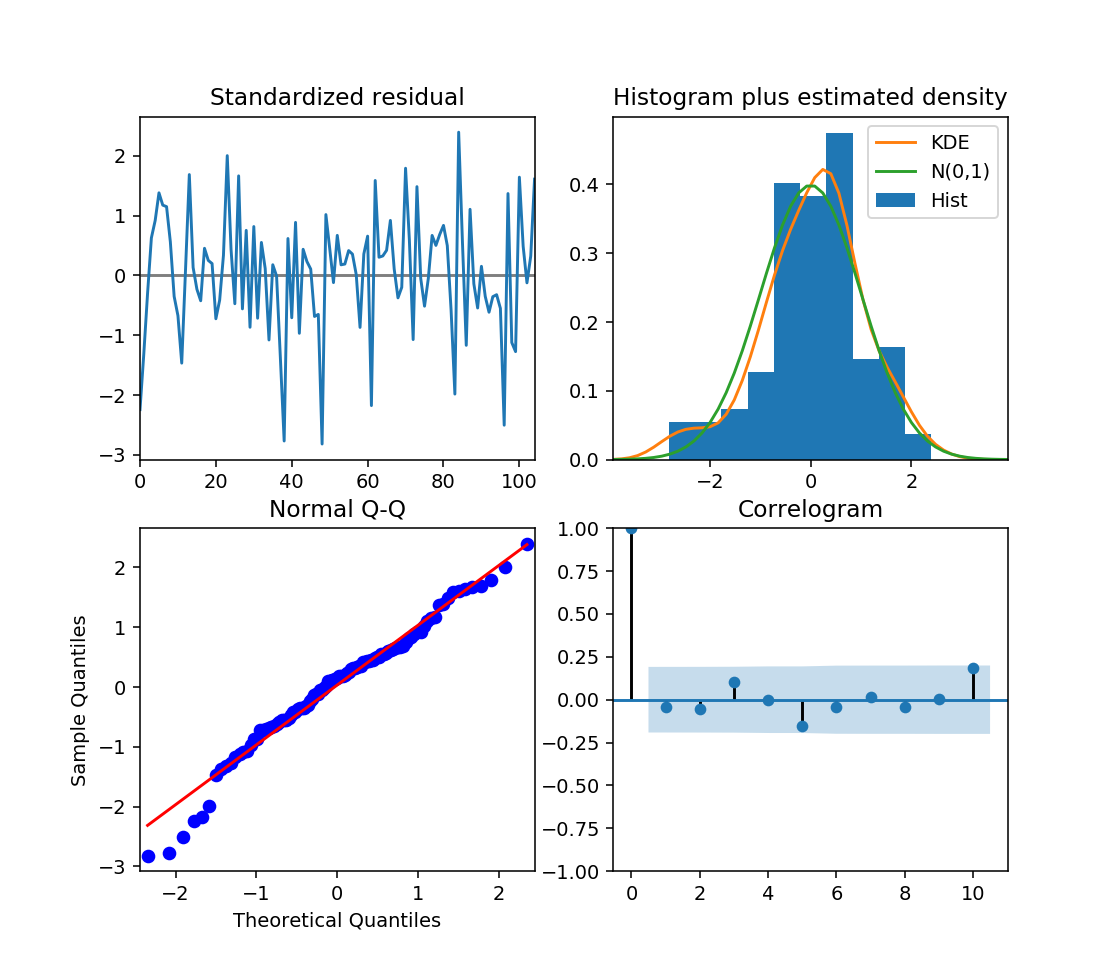

In [11]:
fig = model.plot_diagnostics(figsize=(8,7))

The top left panel shows the residuals, which appear mostly random. The histogram in the top right panel shows the distribution of the reisiduals. We can see from the estimated density (orange curve) that the residuals are approximately normally distributed. The Q-Q plot on the bottom left panel compares the shape of the distribution of temperature data and temperature data predicted by the model. The plot is linear except at low extreme values, indicating similarity between the data and predictions. The bottom right panel shows the autocorrelation plot, and from it we see that the model predictions have only small correlations with prior predictions in time. Although not perfect, the model has generally satisfied the statistical requirements for vaildity on the temperature data. 

The model was created using the training set, and the residuals between the model predictions and actual data were examined using the training set. Now, the test set can be used to see how our model performs on unknown data. 
Model precitions are plotted along with the test set below:

<IPython.core.display.Javascript object>


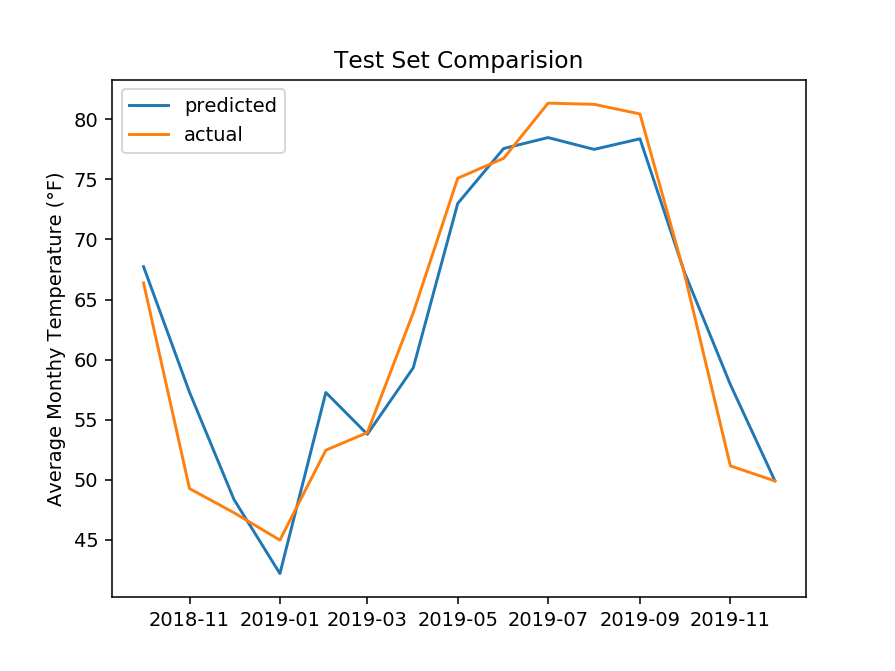

In [12]:
predicted_temps = pd.DataFrame(model.predict(n_periods=15), index=test.index)

plt.figure()
plt.plot(predicted_temps, label='predicted')
plt.plot(test, label='actual')
plt.ylabel('Average Monthy Temperature (°F)')
plt.title('Test Set Comparision')
plt.legend()

The model seems to capture the monthly average temperature pattern well. To evaluate the model accuracy, I use a test metric called [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error). This formula summarizes the percent error our model has with respect to the test set. The pmdarima package provides this metric:

In [13]:
from pmdarima.metrics import smape
smape(test, predicted_temps)

4.644415402928957

The error rate is about 4.64% on the test set.

Now, I can produce a forecast for the average monthly temperature in 2020. But first, I update the model using the test data. This is done to allow the model to learn as much as possible for future forecasts. Again, the pmdarima package provides a built-in update method:

In [14]:
model.update(test)

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 0, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

Now, I can create a forecast for 2020 monthly average temperatures. It's worth noting that any forecast will have uncertainty in its predictions, and this uncertainty can be captured with a 95% confidence interval around the predictions.

In [15]:
next_year_temps, ci = model.predict(n_periods=12, return_conf_int=True)

time_range = pd.date_range(start='1/1/20', end = '12/31/20', freq='MS')
next_year = pd.DataFrame(next_year_temps, index=time_range)

<IPython.core.display.Javascript object>


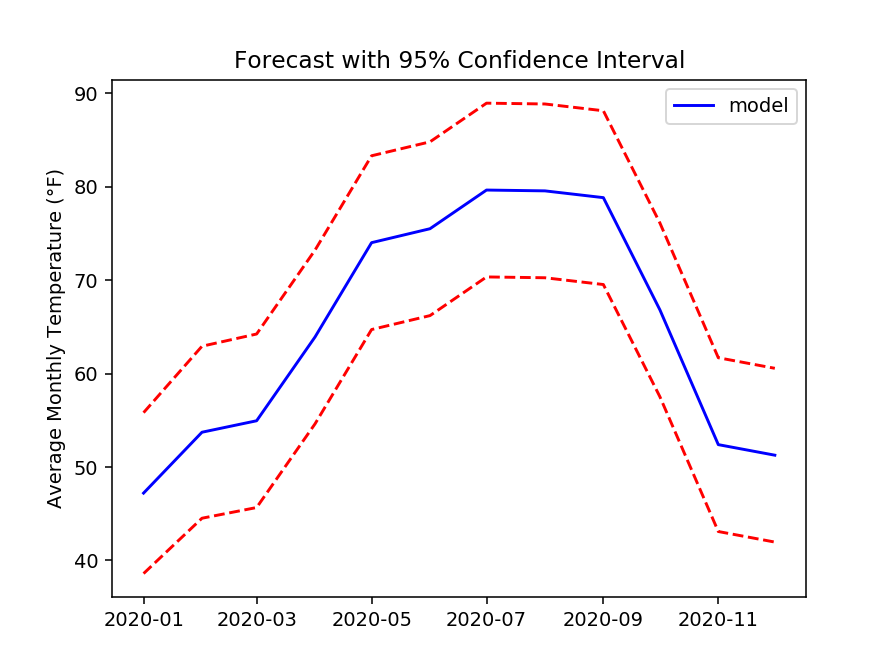

In [16]:
plt.figure()
plt.plot(next_year.index, next_year, 'b', label='model')
plt.plot(next_year.index, ci[:,0], 'r--')
plt.plot(next_year.index, ci[:,1], 'r--')
plt.ylabel('Average Monthly Temperature (°F)')
plt.title('Forecast with 95% Confidence Interval')
plt.legend()

The confidence interval is fairly wide, which reflects the underlying uncertainty in the forecast. In context, this result makes sense; I haven't used any physical data or meteorological methods to create this forecast. But simply applying time series math has produced a forecast that wouldn't be unreasonable for a typical year in Atlanta.

One limitation of the model I've used here is the limited time frame. The model could be improved significantly if a larger time frame is used for training. Unfortunately, some Atlanta airports only started collecting data in 2005, so only data from the Hartsfield-Jackson airport could be used for modeling. 

Regardless, simple forecasting has provided a good overview of temperature patterns in Atlanta. 